# Modelling the glitch

With `asterion.GlitchModel`, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

from asterion.models import GlitchModel, HeGlitchPrior, CZGlitchPrior, AsyPrior
from asterion.inference import Inference

from corner import corner

## Data

Import stellar evolutionary track.

In [2]:
track = pd.read_csv('data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


Choose a star from the evolutionary track.

In [3]:
profile = track.loc[708]

Extract modes from star.

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2357.69 muHz
delta_nu ~ 111.84 muHz


## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameters `alpha` and `epsilon`, but by default these are fairly uninformative.

In [6]:
delta_nu = (delta_nu_fit, 0.5)
nu_max = (nu_max_sca, 0.05*nu_max_sca)

In [7]:
background = AsyPrior(delta_nu)
he_glitch = HeGlitchPrior(nu_max)
cz_glitch = CZGlitchPrior(nu_max)

In [8]:
model = GlitchModel(background, he_glitch, cz_glitch)

What are our model arguments? We can check the docs for the `__call__` method of `model`. 

In [9]:
help(model.__call__)

Help on method __call__ in module asterion.models:

__call__(n: 'ArrayLike', nu_obs: 'ArrayLike' = None, nu_err: 'ArrayLike' = None, pred: 'bool' = False, num_pred: 'int' = 250) method of asterion.models.GlitchModel instance
    Sample the model for given observables.
    
    Args:
        n: Radial order for the given modes.
        nu_obs: Observed radial mode frequencies.
        nu_err: Gaussian observational uncertainties (sigma) for nu_obs.
        pred: If True, make predictions nu and nu_pred from n and num_pred.
        num_pred: Number of predictions in the range n.min() to n.max().



### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [10]:
infer = Inference(model, seed=42)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [11]:
infer.prior_predictive(model_args=(n,), model_kwargs={'pred': True})

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

In [12]:
results = infer.get_results()

In [13]:
results.data

Inference data with groups:
	> prior

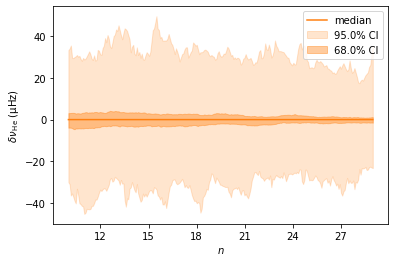

In [14]:
quantiles = [.025, .16, .84, .975]
model.plot_glitch(results.data, kind='He', group='prior', observed=False, quantiles=quantiles);

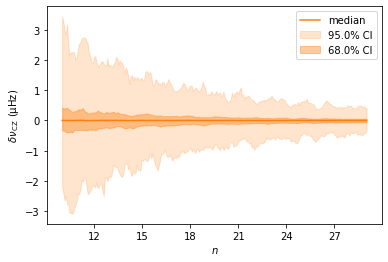

In [15]:
model.plot_glitch(results.data, kind='CZ', group='prior', observed=False, quantiles=quantiles);

#### Sample posterior

We sample from the posterior using the `numpyro` NUTS sampler. This should take about a minute.

In [16]:
infer.sample(model_args=(n,), model_kwargs={'nu_obs': nu}, num_chains=5)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
infer.posterior_predictive(model_args=(n,), model_kwargs={'nu_obs': nu, 'pred': True})

In [18]:
results = infer.get_results()
results.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

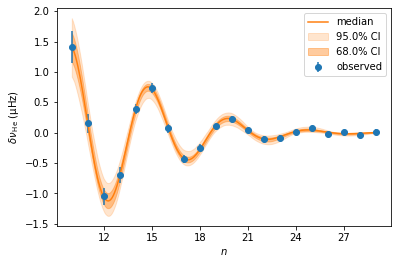

In [19]:
model.plot_glitch(results.data, kind='He', quantiles=quantiles);

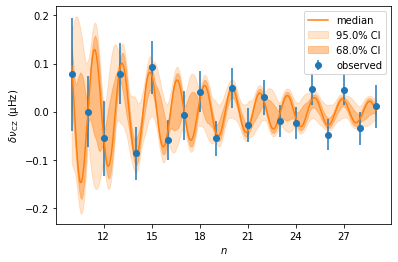

In [20]:
model.plot_glitch(results.data, kind='CZ', quantiles=quantiles);

In [22]:
results.get_var_names()

['a_cz',
 'a_he',
 'b_he',
 'delta_nu',
 'dnu_cz',
 'dnu_he',
 'epsilon',
 'kernel_length',
 'log_a_cz',
 'log_a_he',
 'log_b_he',
 'log_tau_cz',
 'log_tau_he',
 'noise',
 'nu_bkg',
 'phi_cz',
 'phi_cz_unwrapped',
 'phi_he',
 'phi_he_unwrapped',
 'tau_cz',
 'tau_he']

Lets have a look at the trace plot for the model parameters.

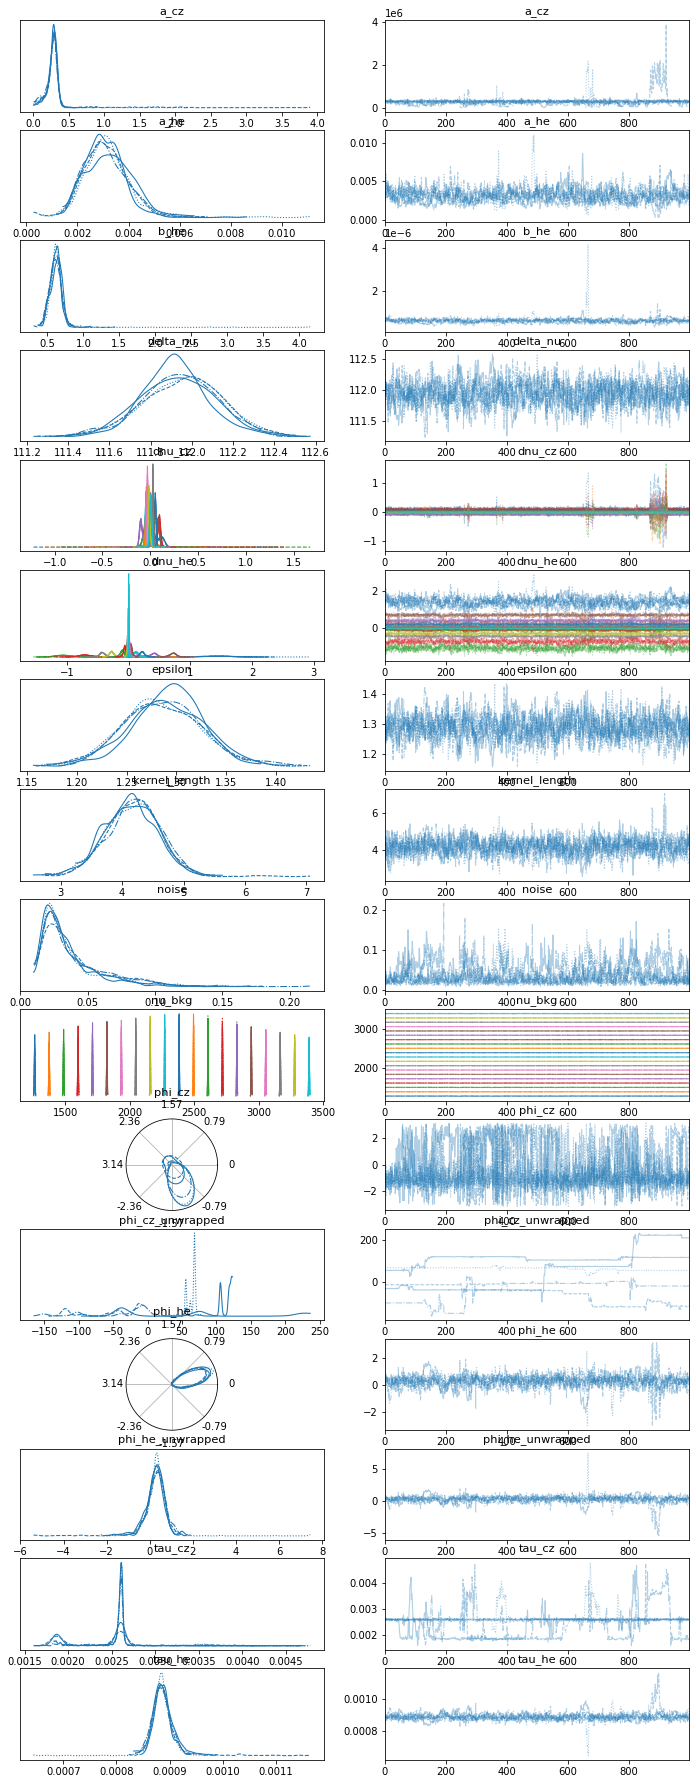

In [26]:
az.plot_trace(results.data, var_names=r'^((?!log).)*$', filter_vars='regex',
              circ_var_names=results.circ_var_names);

The data works with the `corner` module too.

In [49]:
labels = [f'{k} ({v.to_string("latex_inline")})' if str(v) != '' else k for k, v in background.units.items()]

In [52]:
def plot_corner(model):
    quantiles = [.16, .5, .84]
    labels = [f'{k} ({v.to_string("latex_inline")})' if str(v) != '' else k for k, v in model.units.items()]
    fig = corner(
        results.data, 
        var_names=list(model.units.keys()), 
        divergences=True,
        quantiles=quantiles,
        labels=labels
    )
    return fig

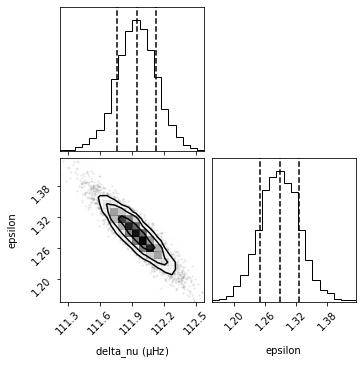

In [53]:
plot_corner(background);

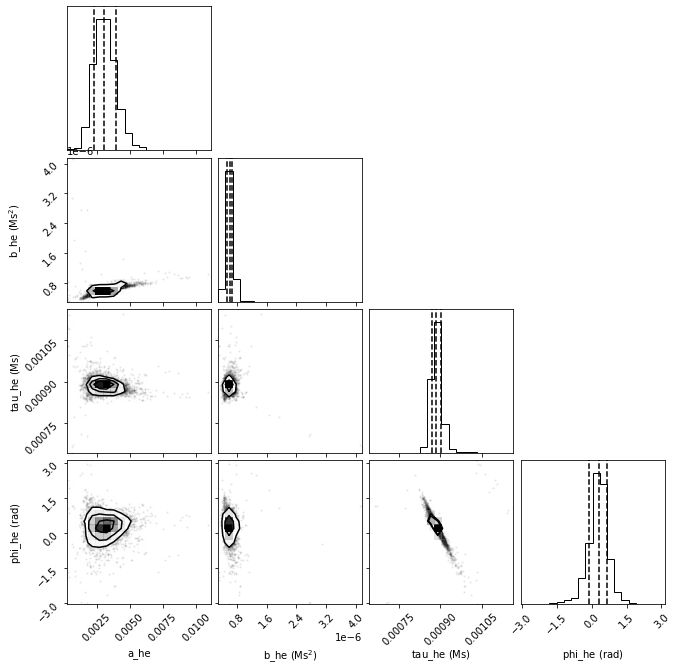

In [54]:
plot_corner(he_glitch);

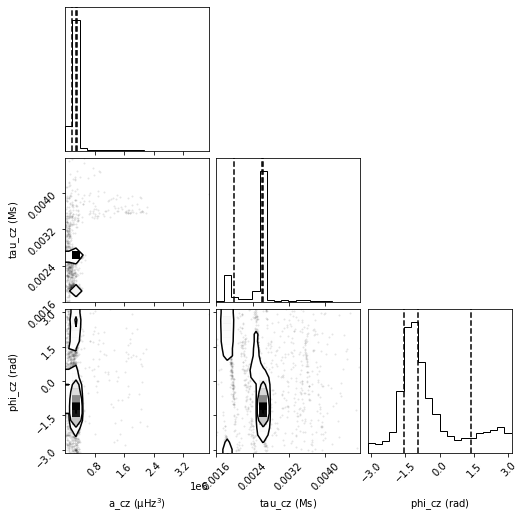

In [55]:
plot_corner(cz_glitch);

In [58]:
results.save('out/glitch_no_err')

## Model with observational error

Synthesise observational error.

In [59]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [60]:
rng = np.random.default_rng(42)

In [61]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [62]:
nu_obs = add_noise(rng, nu, nu_err)

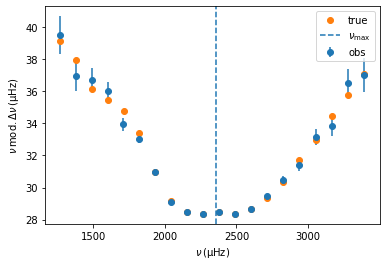

In [63]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [65]:
nu_err

array([1.18440898e+00, 9.55814737e-01, 7.52719145e-01, 5.72198344e-01,
       4.16434127e-01, 2.86038937e-01, 1.81007332e-01, 9.94748044e-02,
       4.17027255e-02, 8.55565859e-03, 3.78361795e-04, 1.72087208e-02,
       5.92086931e-02, 1.26606938e-01, 2.19686184e-01, 3.38567162e-01,
       4.82994170e-01, 6.53421847e-01, 8.49161061e-01, 1.07041305e+00])

In [67]:
infer.sample(model_args=(n,), model_kwargs={'nu_obs': nu_obs, 'nu_err': nu_err}, num_chains=5)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [68]:
infer.posterior_predictive(model_args=(n,), model_kwargs={'nu_obs': nu_obs, 'nu_err': nu_err, 'pred': True})

In [69]:
results = infer.get_results()
results.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

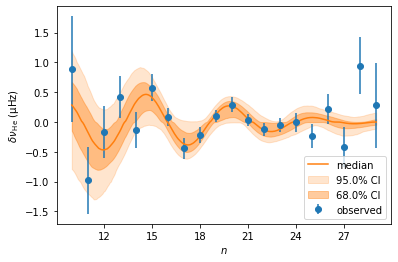

In [72]:
quantiles = [.025, .16, .84, .975]
model.plot_glitch(results.data, kind='He', quantiles=quantiles);

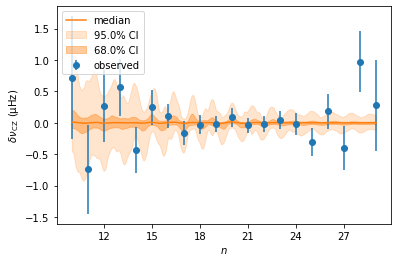

In [73]:
model.plot_glitch(results.data, kind='CZ', quantiles=quantiles);

Lets have a look at the trace plot for the model parameters.

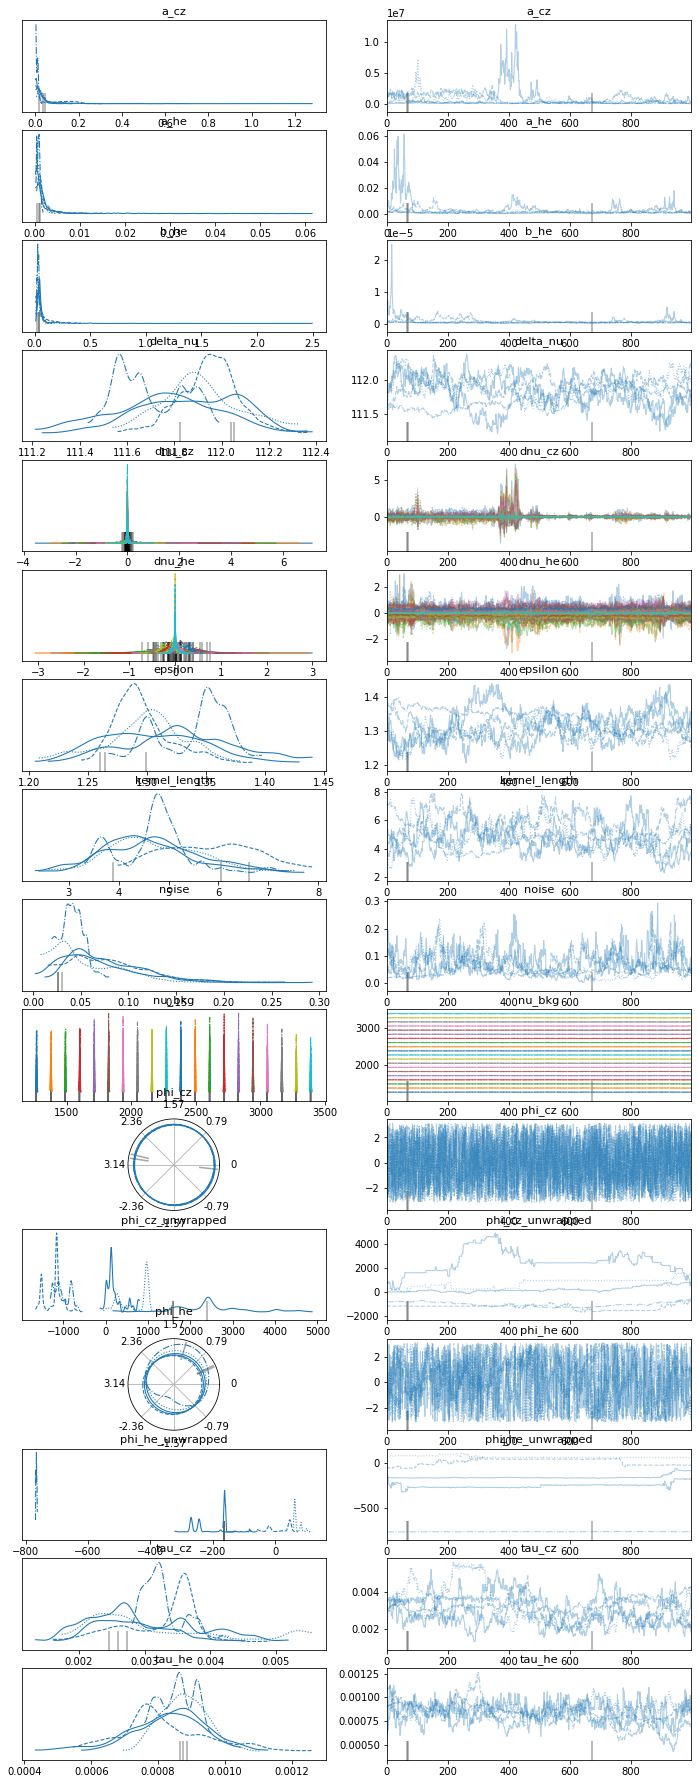

In [75]:
az.plot_trace(results.data, var_names=r'^((?!log).)*$', filter_vars='regex',
              circ_var_names=results.circ_var_names);

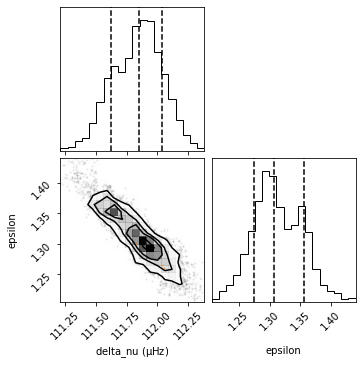

In [76]:
plot_corner(background);

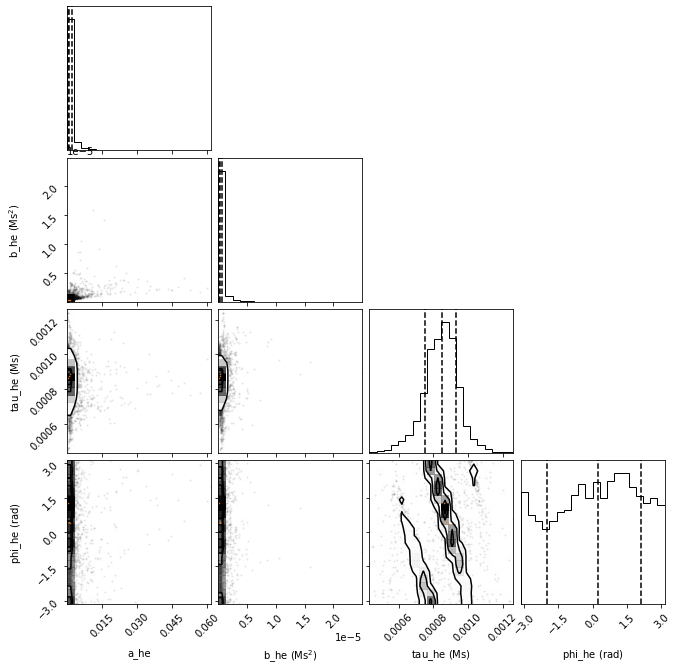

In [77]:
plot_corner(he_glitch);

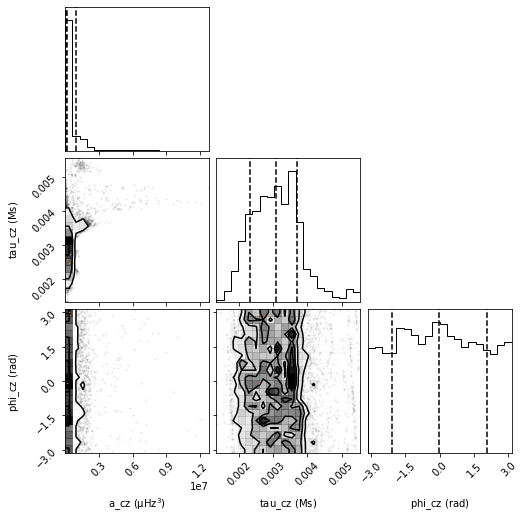

In [78]:
plot_corner(cz_glitch);

In [79]:
results.save('out/glitch_with_err')